In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import unpickle
from qualitative import QualitativeAnalysis
from segmentor import Segmentor

In [3]:
best = '4566c335e71f215a1110a36a7cfec1882c86f86dbb7e3e5787dfdc26'
model, _, _ = unpickle(f'results/{best}_experiment_results.pkl')

In [4]:
s = Segmentor(model, min_frames=10, threshold=0.7)

In [29]:
s._download_youtube_video('4IP_E7efGWE')

Title: Little kittens meowing and talking - Cute cat video


'Little kittens meowing and talking - Cute cat video.mp4'

In [13]:
class_names = {0: 'Not', 1: 'Kissing'}
img_size = 224

In [30]:
videos_and_frames = {
    'Little kittens meowing and talking - Cute cat video.mp4': list(range(20))
}

In [ ]:
model()

In [31]:
q = QualitativeAnalysis(
    model,
    img_size,
    videos_and_frames,
    class_names
)

Something went wrong!


chunk:   6%|▌         | 268/4631 [00:00<00:01, 2676.76it/s, now=None]

MoviePy - Writing audio in %s


MoviePy - Done.


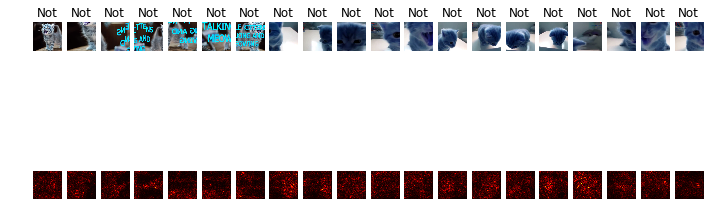

In [32]:
q.saliency_maps()

### params

In [24]:

videos_and_frames = {
    '/Users/aziai/Downloads/movies_casino_royale_2006_kissing_2.mp4': [0, 35, 51],
    '/Users/aziai/Downloads/movies_casino_royale_2006_not_1.mp4': [0, 4, 9],
    '/Users/aziai/Downloads/movies_goldeneye_1995_kissing_1.mp4': [1, 4, 2],
    '/Users/aziai/Downloads/movies_goldeneye_1995_not_2.mp4': [3, 10, 12],
    # new
    '/Users/aziai/Downloads/movies_goldeneye_1995_kissing_2.mp4': [0, 1, 2, 3],
    '/Users/aziai/Downloads/movies_goldeneye_1995_kissing_3.mp4': [0, 1, 2, 3],
    
    '/Users/aziai/Downloads/movies_casino_royale_2006_kissing_1.mp4': [0, 1, 2],
    '/Users/aziai/Downloads/movies_casino_royale_2006_kissing_3.mp4': [0, 1, 2, 3],
}

### Saliency maps

In [25]:
q = QualitativeAnalysis(
    model,
    img_size,
    videos_and_frames,
    class_names
)

Something went wrong!


chunk:  19%|█▊        | 251/1346 [00:00<00:00, 2506.99it/s, now=None]

MoviePy - Writing audio in %s


MoviePy - Done.
Something went wrong!


MoviePy - Writing audio in %s
MoviePy - Done.


Something went wrong!


MoviePy - Writing audio in %s
MoviePy - Done.


Something went wrong!


chunk:  45%|████▌     | 220/486 [00:00<00:00, 2195.75it/s, now=None]

MoviePy - Writing audio in %s


MoviePy - Done.
Something went wrong!


MoviePy - Writing audio in %s
MoviePy - Done.


Something went wrong!


chunk:  29%|██▉       | 143/486 [00:00<00:00, 1380.87it/s, now=None]

MoviePy - Writing audio in %s


MoviePy - Done.
Something went wrong!


MoviePy - Writing audio in %s
MoviePy - Done.


Something went wrong!


MoviePy - Writing audio in %s
MoviePy - Done.


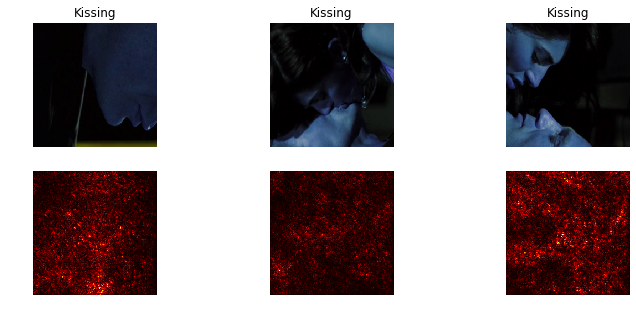

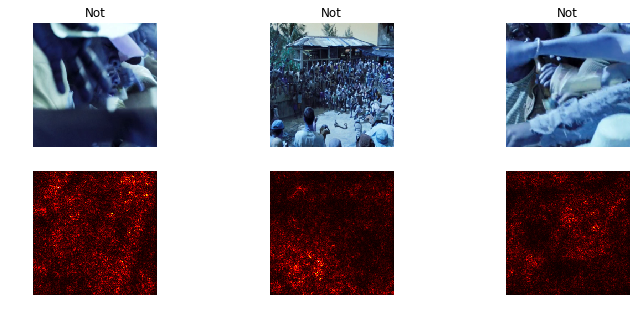

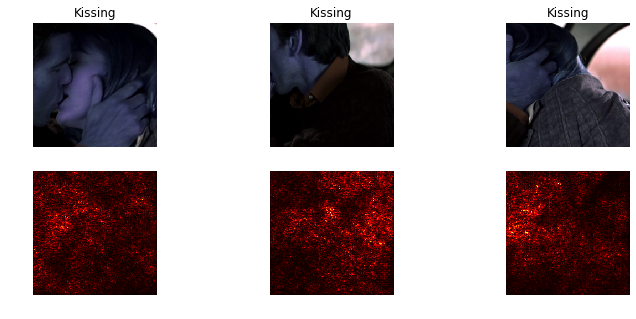

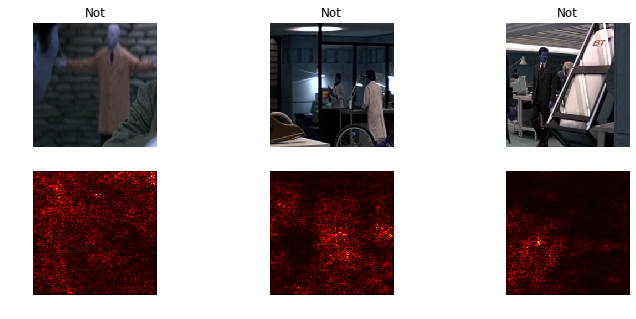

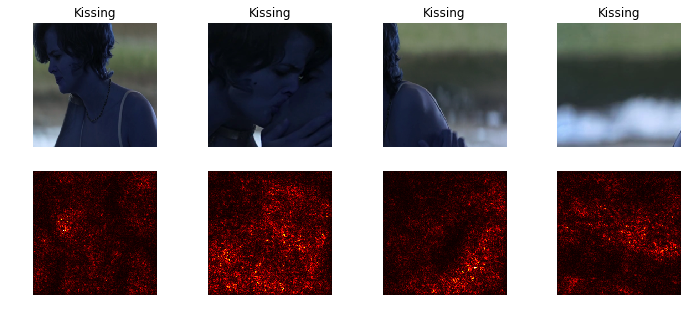

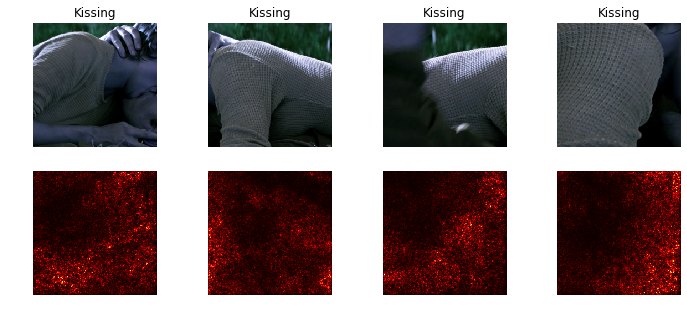

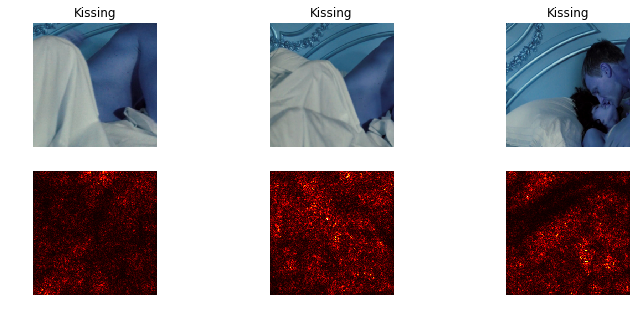

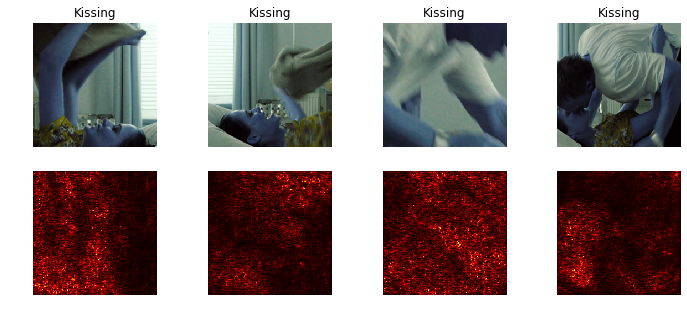

In [26]:
q.saliency_maps()

### Class visualization

In [57]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt

import torch
import random
import params
from pipeline import BuildDataset

In [58]:
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [59]:
list(q.features.keys())[0]

'/Users/aziai/Downloads/movies_casino_royale_2006_kissing_2.mp4'

In [74]:
def create_class_visualization(target_y, model, dtype, a, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    
    def deprocess(x):
        return BuildDataset.transform_reverse(x.squeeze(0))
    
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        target = model(a, img)[0, target_y]
        target.backward()
        g = img.grad.data
        g -= 2 * l2_reg * img.data
        img.data += learning_rate * (g / g.norm())
        img.grad.zero_()

        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-params.mean[c] / params.std[c])
            hi = float((1.0 - params.mean[c]) / params.std[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

In [86]:
a = q.features[list(q.features.keys())[0]][0][0].unsqueeze(0)

In [87]:
dtype = torch.FloatTensor

target_y = 1 # kissing
# target_y = 0 # not


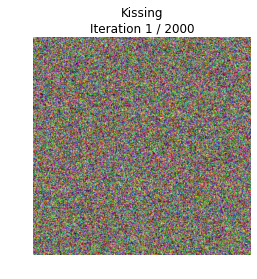

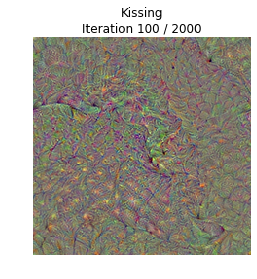

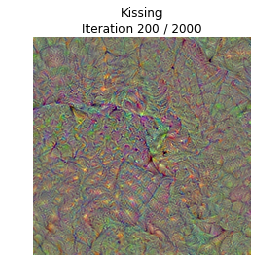

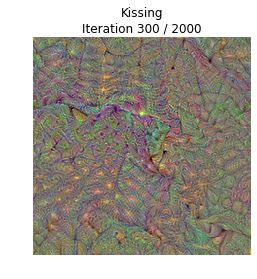

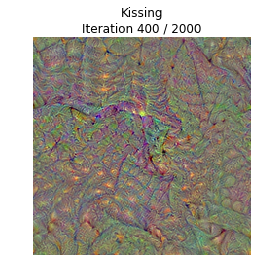

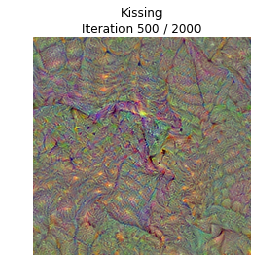

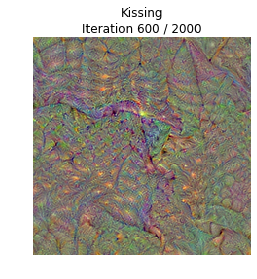

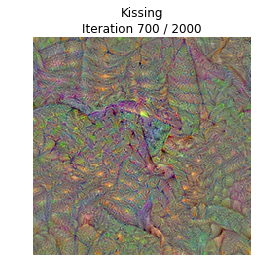

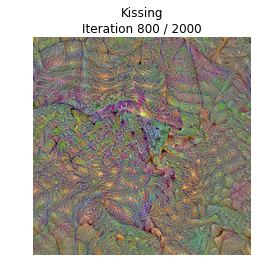

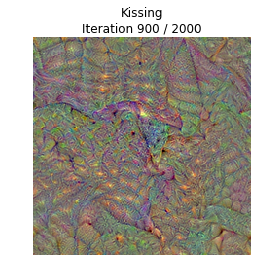

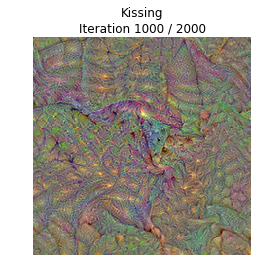

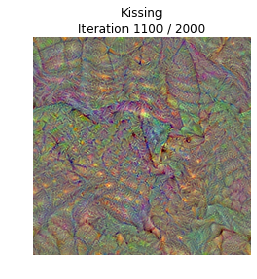

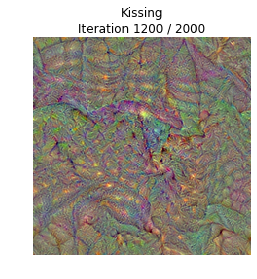

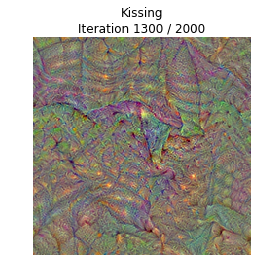

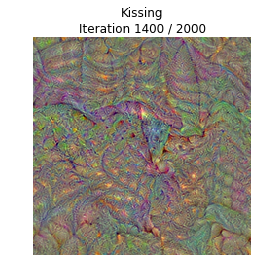

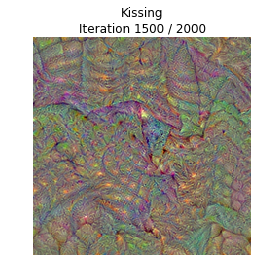

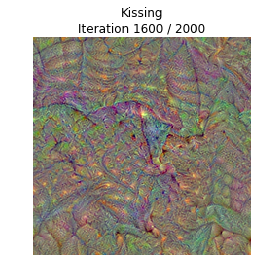

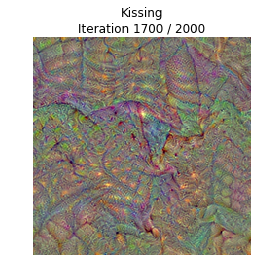

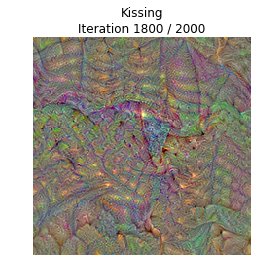

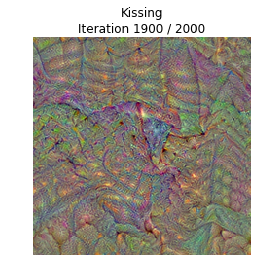

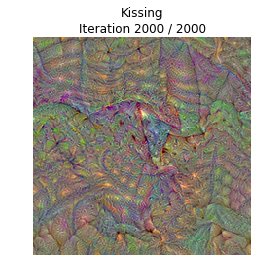

In [79]:
out = create_class_visualization(target_y, model, dtype, a,
                                 num_iterations=2000,
                                 show_every=100)

In [ ]:
q = QualitativeAnalysis(model, 224, videos_and_frames, class_names)

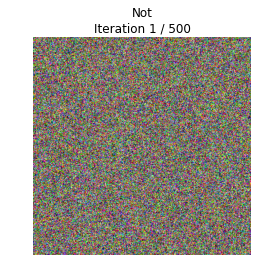

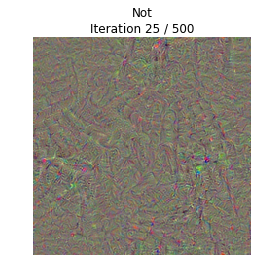

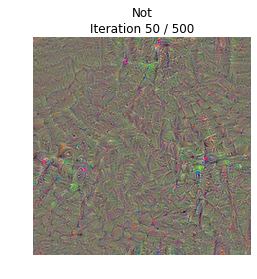

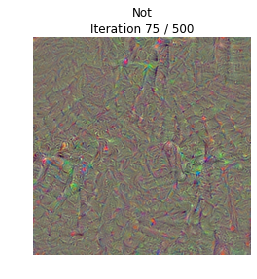

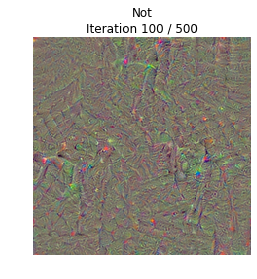

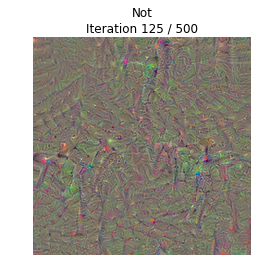

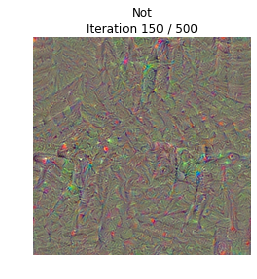

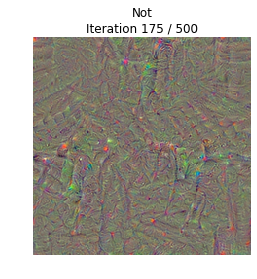

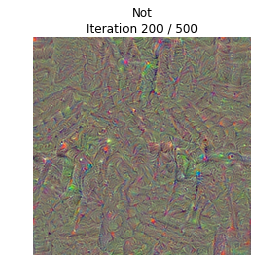

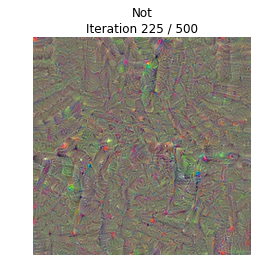

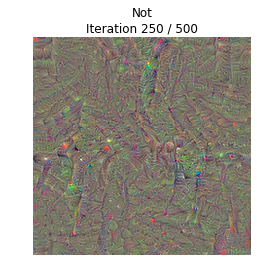

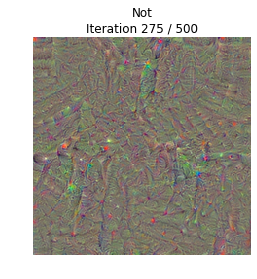

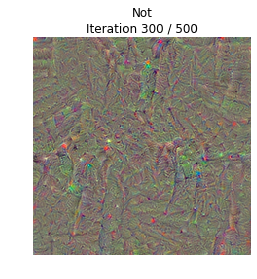

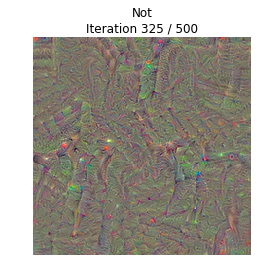

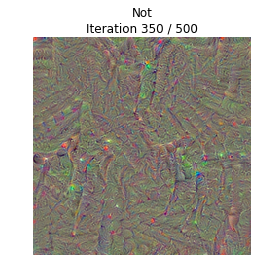

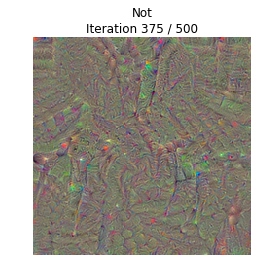

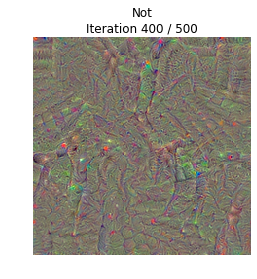

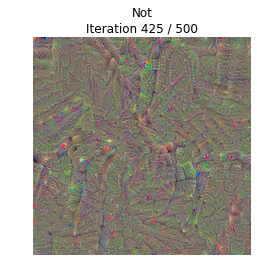

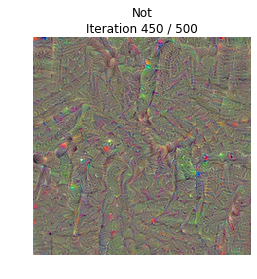

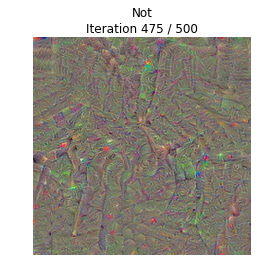

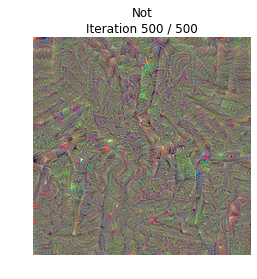

In [90]:
out = create_class_visualization(0, model, dtype, a,
                                 num_iterations=500,
                                 show_every=25)